In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import gaussian_filter
import tqdm
from joblib import Parallel, delayed
from markov_functions import *
from itertools import product
import warnings
import seaborn as sns
import ast

In [2]:
pa_pitches_filename = './data/paired_filtered.csv'  # or provide a full path

if not os.path.exists(pa_pitches_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{pa_pitches_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")



pas = pd.read_csv(pa_pitches_filename)
pas.drop(['pa_seq', 'bases', 'velocities_events', 'pitchCodes_events'], axis=1, inplace=True)

In [3]:
pitcher  = '古林睿煬'
# batter   = '魔鷹'
# catcher  = '陳重羽'

pitcher_df = pas[(pas['pitcherName'] == pitcher)]
# batter_df  = pas[(pas['batterName'] == batter)]

batter_df = pas[pas['batterName'].isin(pas['batterName'].unique())]
opposite_batter = batter_df[batter_df['batterHand'] != batter_df['pitcherHand']]
samehand_batter = batter_df[batter_df['batterHand'] == batter_df['pitcherHand']]

opposite_hand = (pitcher_df['pitcherHand'].values[0] != samehand_batter['batterHand'].values[0])


In [4]:
counts = {
    'ball': [0, 1, 2, 3],
    'strike': [0, 1, 2],
}

pitcher_events, pitcher_event_list = get_pitches_with_counts(pitcher_df, opposite_hand=opposite_hand, **counts)
batter_events, batter_event_list = get_pitches_with_counts(samehand_batter, opposite_hand=opposite_hand, **counts)



In [16]:

store_result = f'temp_{pitcher}_{opposite_hand}.csv'
if os.path.exists(store_result): os.remove(store_result)


n_pitch_init = 1
strike_init = 1
ball_init = 0
pa_end_init = False
good_ending_init = False

situation_params_init = {
    'pitch_type_last': 0,
    'coords_quadrant_last': 1,
    'swing_last': False,
    'whiff_last': False,
    'pitch_type_last2': None,
    'coords_quadrant_last2': None,
    'swing_last2': None,
    'whiff_last2': None
}


def simulate_pa(_):
    # Initialize variables for a single plate appearance
    n_pitch = n_pitch_init
    strike = strike_init
    ball = ball_init
    pa_end = pa_end_init
    good_ending = good_ending_init
    situation_params = situation_params_init.copy()

    pitch_coord_sequence = []
    pitch_types_sequence = []
    pitch_results_sequence = []
    ending_type = None

    # Initial probability maps
    pitchtype_map, swing_map, whiff_map, inplay_map, soft_map, called_strike_zone = counts_prob(
        f'{ball}-{strike}', pitcher_event_list, batter_event_list, situation_params=situation_params
    )

    while not pa_end:

        sampled_pitch = sample_pitch(pitchtype_map)
            
        (x_idx, y_idx, pitchtype), (x_sampled, y_sampled, pitchtype) = sampled_pitch
        pitch_coord_sequence.append((x_sampled, y_sampled))
        pitch_types_sequence.append(pitch_types[pitchtype])
        n_pitch += 1

        if prob_determine(swing_map, x_idx, y_idx, pitchtype): # swing
            situation_params = write_situation(situation_params=situation_params, pitchtype=pitch_types[pitchtype], x=x_sampled, y=y_sampled, swing=True, whiff=prob_determine(whiff_map, x_idx, y_idx, pitchtype))
            if situation_params['whiff_last']: # whiff
                pitch_results_sequence.append('WHIFF')
                if strike < 2:
                    strike += 1
                else:
                    pa_end, good_ending, ending_type = True, True, 'strikeout'
            else: # contact
                if prob_determine(inplay_map, x_idx, y_idx, pitchtype): # in play
                    pa_end = True
                    if prob_determine(soft_map, x_idx, y_idx, pitchtype): # soft contact
                        good_ending, ending_type = True, 'soft-inplay'
                        pitch_results_sequence.append('SOFT-INPLAY')
                    else: # hard contact
                        good_ending, ending_type = False, 'hard-inplay'
                        pitch_results_sequence.append('HARD-INPLAY')
                else: # foul
                    pitch_results_sequence.append('FOUL')
                    if strike < 2: strike += 1
        else: # no swing
            situation_params = write_situation(situation_params=situation_params, pitchtype=pitch_types[pitchtype], x=x_sampled, y=y_sampled, swing=False, whiff=False)
            if prob_determine(called_strike_zone, x_idx, y_idx, pitchtype): # called strike
                pitch_results_sequence.append('CALLED-STRIKE')
                if strike < 2:
                    strike += 1
                else:
                    pa_end, good_ending, ending_type = True, True, 'strikeout'
            else: # ball
                pitch_results_sequence.append('BALL')
                if ball < 3:
                    ball += 1
                else:
                    pa_end, good_ending, ending_type = True, False, 'walk'

        if not pa_end:
            counts = f'{ball}-{strike}'
            fallback_strategies = [
                {},
                {'coords_quadrant_last2': None},
                {'coords_quadrant_last2': None, 'swing_last2': None, 'whiff_last2': None},
                {'pitch_type_last2': None, 'coords_quadrant_last2': None, 'swing_last2': None, 'whiff_last2': None},
                {'pitch_type_last2': None, 'coords_quadrant_last2': None, 'swing_last2': None, 'whiff_last2': None, 'coords_quadrant_last': None},
                {'pitch_type_last2': None, 'coords_quadrant_last2': None, 'swing_last2': None, 'whiff_last2': None, 'coords_quadrant_last': None, 'swing_last': None, 'whiff_last': None},
            ]

            for i, strategy in enumerate(fallback_strategies):
                with warnings.catch_warnings():
                    warnings.simplefilter("error", RuntimeWarning)
                    try:
                        params_copy = situation_params.copy()
                        params_copy.update(strategy)
                        pitchtype_map, swing_map, whiff_map, inplay_map, soft_map, called_strike_zone = counts_prob(
                            counts, pitcher_event_list, batter_event_list, situation_params=params_copy
                        )
                        break  # Success, exit the loop
                    except RuntimeWarning:
                        if i == len(fallback_strategies) - 1:
                            # If all strategies fail, use the initial empty context
                            pitchtype_map, swing_map, whiff_map, inplay_map, soft_map, called_strike_zone = counts_prob(
                                counts, pitcher_event_list, batter_event_list, situation_params=situation_params_init
                            )
                        continue # Try the next strategy

    return {
        'pitch_coord_sequence': pitch_coord_sequence,
        'pitch_types_sequence': pitch_types_sequence,
        'pitch_results_sequence': pitch_results_sequence,
        'ending_type': ending_type,
        'good_ending': good_ending
    }

n_PA = 50
num_processes = max(1, 10)

results = Parallel(n_jobs=num_processes)(
    delayed(simulate_pa)(_) for _ in tqdm.tqdm(range(n_PA), total=n_PA)
)
result_df = pd.DataFrame(results)
result_df.to_csv(store_result, index=False)


 20%|██        | 10/50 [00:00<00:00, 82.28it/s]

TypeError: 'int' object is not iterable

 20%|██        | 10/50 [00:15<00:00, 82.28it/s]

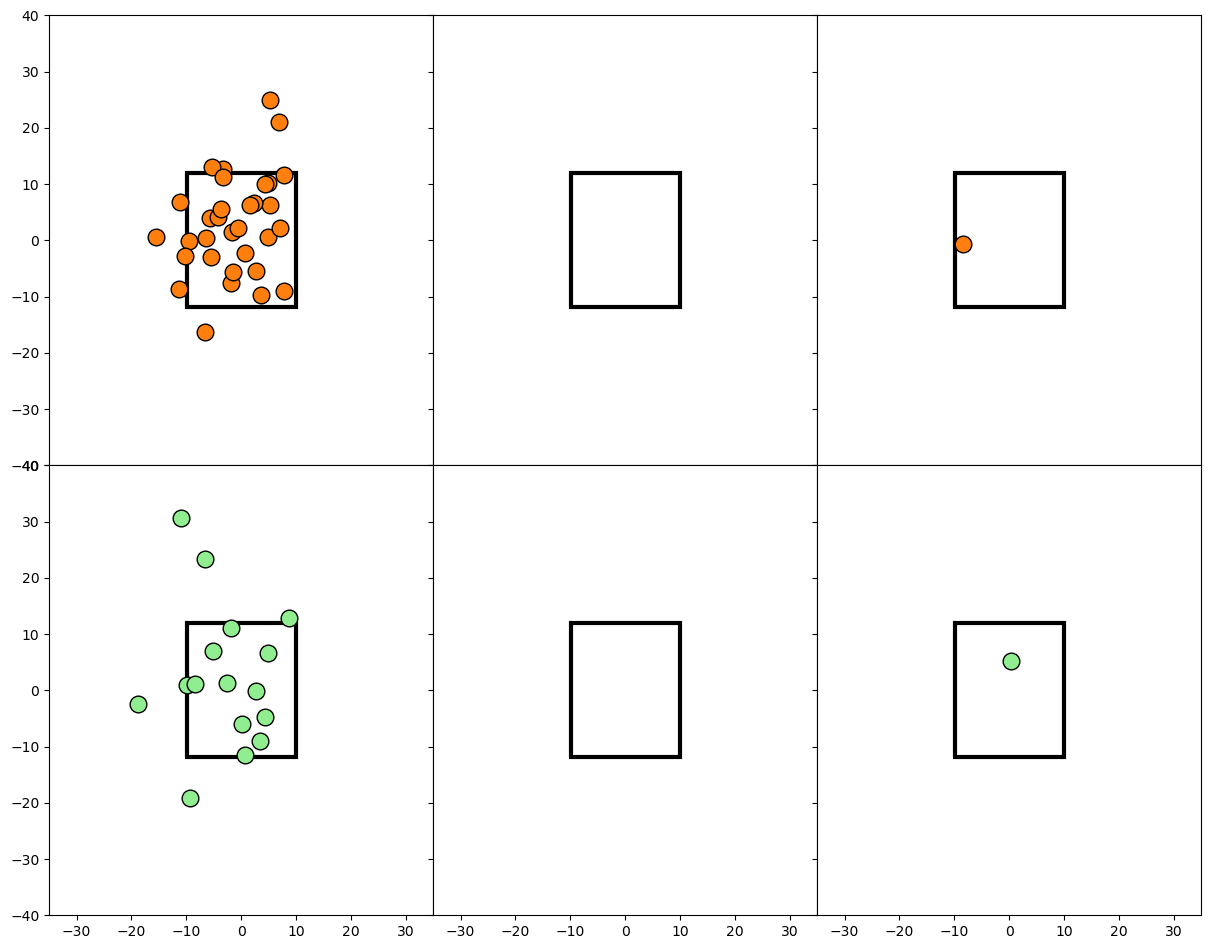

In [ ]:
# Load the simulation results
result_df = pd.read_csv(store_result)
result_df['pitch_types_sequence'] = result_df['pitch_types_sequence'].apply(ast.literal_eval)

min_pitch_len = 0
filtered_df = result_df[result_df['pitch_types_sequence'].apply(len) >= min_pitch_len].copy()
filtered_df['sequence_tuple'] = filtered_df['pitch_types_sequence'].apply(tuple)


good_endings_df = filtered_df[filtered_df['good_ending'] == True]
bad_endings_df = filtered_df[filtered_df['good_ending'] == False]

good_sequence_rank = good_endings_df['sequence_tuple'].value_counts().reset_index()
good_sequence_rank.columns = ['Pitch Sequence', 'Frequency']
bad_sequence_rank = bad_endings_df['sequence_tuple'].value_counts().reset_index()
bad_sequence_rank.columns = ['Pitch Sequence', 'Frequency']


fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0, top=0.95, bottom=0.05, left=0.03, right=0.99)
for i in range(len(good_sequence_rank['Pitch Sequence'])):
    ax = axes[0, :]
    sequence_to_find = good_sequence_rank['Pitch Sequence'][i]
    x, y = next_pitch(good_endings_df, sequence_to_find, axes=ax, color='C1')

    for i in range(3):
        ax[i].plot(x[i], y[i], 'o', color='C1', markersize=12, markeredgecolor='k', markeredgewidth=1)


for i in range(len(bad_sequence_rank['Pitch Sequence'])):
    ax = axes[1, :]
    sequence_to_find = bad_sequence_rank['Pitch Sequence'][i]
    x, y = next_pitch(bad_endings_df, sequence_to_find, axes=ax, color='lightgreen')
    for i in range(3):
        ax[i].plot(x[i], y[i], 'o', color='lightgreen', markersize=12, markeredgecolor='k', markeredgewidth=1)


for ax in axes.flatten():
    plotting_background(ax)
    ax.set_xlim(-35, 35)
    ax.set_ylim(-40, 40)

plt.show()
plt.close('all')
